In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from pytz import timezone
import pytz
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
%matplotlib inline

import plotly
import plotly.graph_objs as go
from plotly.offline import plot
from plotly import tools

from sklearn import linear_model


In [2]:
# Read trip data
Data_X = pd.read_csv('UberPriceTrackX.csv')
Data_Pool = pd.read_csv('UberPriceTrackPool.csv')
Data_X.head()

,Time,None,Price,Duration,Distance,Wait_Time
0,2018-11-08 17:51:51.493805,1541699632,8.71,960,3.27,4
1,2018-11-08 17:55:56.128564,1541699877,8.71,960,3.27,3
2,2018-11-08 17:56:57.918118,1541699939,8.71,960,3.27,2
3,2018-11-08 17:57:59.659881,1541700001,8.71,960,3.27,2
4,2018-11-08 17:59:01.625413,1541700063,8.71,960,3.27,4


In [3]:
def time_converter(Data):
    
    """
    Converts given time from UTC to specified timezone
    """
    date = list(Data['Time'])

    converted_date = []
    
    for date in date:
        converted_date.append(convert_time(date))

    Data['Converted Time'] = converted_date
    Data_df = Data[['Time','Converted Time','Price','Duration','Distance','Wait_Time']]
    
    return Data_df, converted_date

def convert_time(dt):
    
    """
    Converts given time from UTC to specified timezone
    Also removes pytz timezone information as to not mess with plotting
    """
    
    date_format='%Y-%m-%d %H:%M:%S.%f'

    date_current_utc = datetime.strptime(dt, date_format)
    date_current_utc = pytz.utc.localize(date_current_utc).astimezone(pytz.UTC)
    
    date_changed = date_current_utc.astimezone(timezone('US/Pacific'))
    
    # Remove timezone information cause it messes with the plotting
    date_changed = date_changed.replace(tzinfo=None)
    return date_changed

In [4]:
Data_X, Converted_Date_X = time_converter(Data_X)
Data_Pool, Converted_Date_Pool = time_converter(Data_Pool)

In [5]:
Data_X.head()

,Time,Converted Time,Price,Duration,Distance,Wait_Time
0,2018-11-08 17:51:51.493805,2018-11-08 09:51:51.493805,8.71,960,3.27,4
1,2018-11-08 17:55:56.128564,2018-11-08 09:55:56.128564,8.71,960,3.27,3
2,2018-11-08 17:56:57.918118,2018-11-08 09:56:57.918118,8.71,960,3.27,2
3,2018-11-08 17:57:59.659881,2018-11-08 09:57:59.659881,8.71,960,3.27,2
4,2018-11-08 17:59:01.625413,2018-11-08 09:59:01.625413,8.71,960,3.27,4


In [6]:
# Dynamic Graphing for zoomable plots with overlays

trace_high = go.Scatter(
    x=Converted_Date_X,
    y=Data_X['Price'],
    name = "Uber X",
    line = dict(color = '#17BECF'),
    opacity = 0.8)

trace_low = go.Scatter(
    x=Converted_Date_Pool,
    y=Data_Pool['Price'],
    name = "UberPool",
    line = dict(color = '#7F7F7F'),
    opacity = 0.8)

data = [trace_high,trace_low]

layout = dict(
    title='Uber Price Comparison',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

fig = dict(data=data, layout=layout)

# Unmute to generate plot
# plotly.offline.plot(fig, filename = "Price_Comparison_Plot.html")

Text(0,0.5,'Trip Price ($)')

<Figure size 432x288 with 0 Axes>

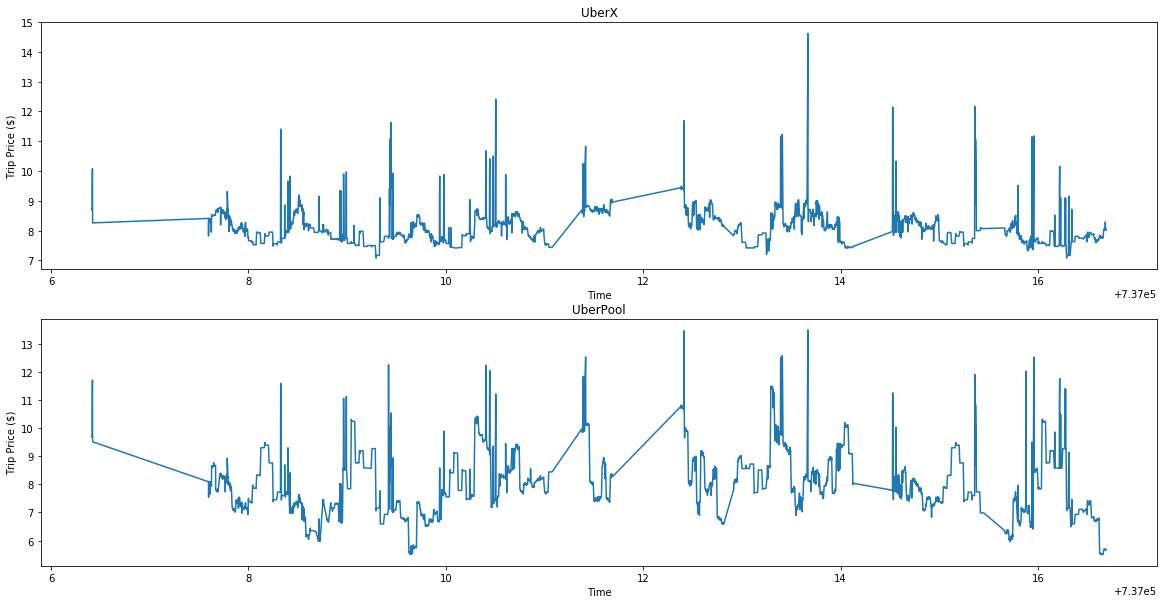

In [7]:
# Simpler inline plots

plt.subplots_adjust(hspace = 2)

f = plt.figure(figsize=(20,10))

ax = f.add_subplot(211)
ax2 = f.add_subplot(212)

dates_X = matplotlib.dates.date2num(Data_X['Converted Time'].tolist())
ax.plot(dates_X, Data_X['Price'])
ax.set_title("UberX")
ax.set_xlabel('Time')
ax.set_ylabel('Trip Price ($)')

dates_Pool = matplotlib.dates.date2num(Data_Pool['Converted Time'].tolist())
ax2.plot(dates_Pool, Data_Pool['Price'])
ax2.set_title("UberPool")
ax2.set_xlabel('Time')
ax2.set_ylabel('Trip Price ($)')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a7fa208>]],
      dtype=object)

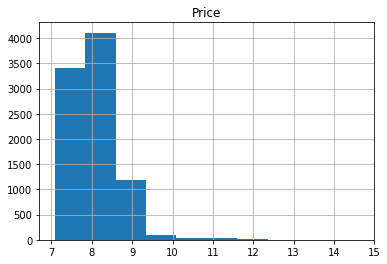

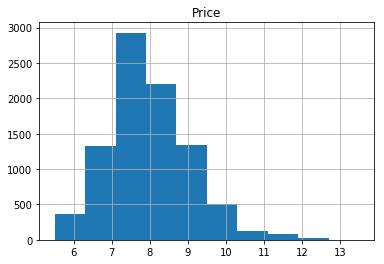

In [8]:
# Histograms for Pricing
Data_X.hist('Price')
Data_Pool.hist('Price')

# Regression

In [9]:
def get_hour_minute(s): 
    hours = s['Converted Time'].dt.hour.map(str)
    minutes = s['Converted Time'].dt.minute.map(str)
    
    hour_minute = hours + ':' + minutes
    hour_minute_f = hours + '.' + minutes
    hour_minute_float = hour_minute_f.map(float)
    s = []
    for i in hour_minute:
        s.append(datetime.strptime(i, '%H:%M'))
    return s, hour_minute_float

def get_day(Uber_data):
    Uber_data['days'] = pd.to_datetime(Uber_data['Converted Time']).dt.day_name()
    Uber_data['hour minute'], Uber_data['hour minute float'] = get_hour_minute(Uber_data)
    return Uber_data



In [10]:
# Get Weekdays and save to days column
Data_X = get_day(Data_X)
Data_Pool = get_day(Data_Pool)


In [11]:
# Remove data from weekend
Data_X_rmWeekend = Data_X[(Data_X.days != 'Saturday')]
Data_X_rmWeekend = Data_X_rmWeekend[(Data_X_rmWeekend.days != 'Sunday')]

Data_Pool_rmWeekend = Data_Pool[(Data_Pool.days != 'Saturday')]
Data_Pool_rmWeekend = Data_Pool_rmWeekend[(Data_Pool_rmWeekend.days != 'Sunday')]

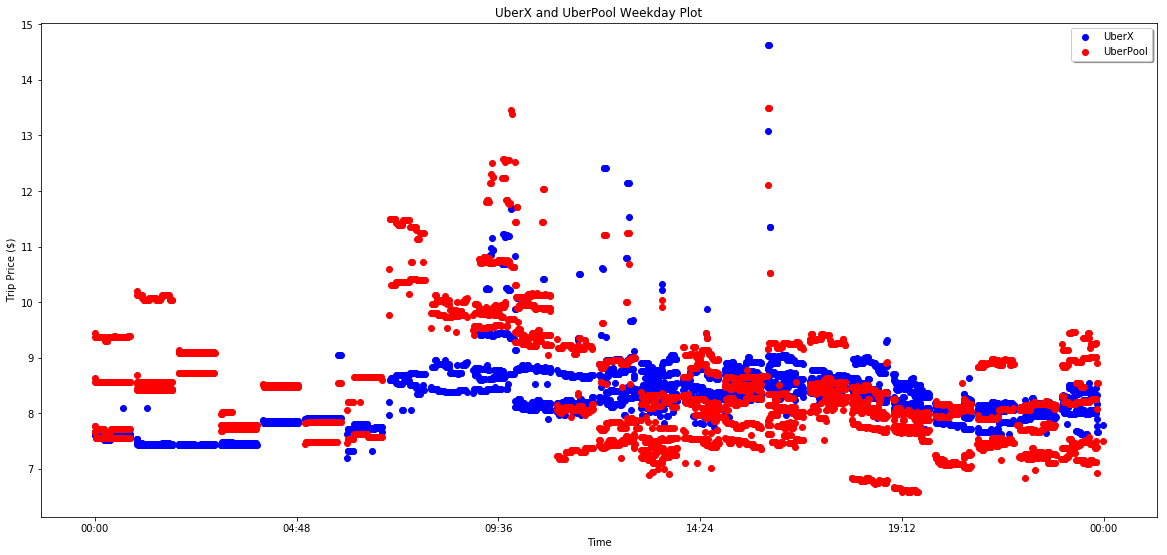

In [12]:
# Plot scatter of UberX and UberPool prices by time for Regression
myFmt = mdates.DateFormatter('%H:%M')
f1 = plt.figure(figsize=(20,20))
ax3 = f1.add_subplot(211)

hour_X = matplotlib.dates.date2num(Data_X_rmWeekend['hour minute'].tolist())
hour_Pool = matplotlib.dates.date2num(Data_Pool_rmWeekend['hour minute'].tolist())

ax3.scatter(hour_X, Data_X_rmWeekend['Price'], color='blue', label='UberX')
ax3.scatter(hour_Pool, Data_Pool_rmWeekend['Price'], color='red', label='UberPool')
ax3.xaxis.set_major_formatter(myFmt)
ax3.set_title("UberX and UberPool Weekday Plot")
ax3.set_xlabel('Time')
ax3.set_ylabel('Trip Price ($)')
ax3.legend(shadow=True)



In [13]:
def predict_price(uber_data, prediction_x):
    X_train = np.vstack((uber_data['hour minute float']))
    Y_train = np.array(uber_data['Price'])
    
    # Create linear regression object
    regr = linear_model.LinearRegression()
    # Train the model using the training sets
    regr.fit(X_train, Y_train);
    
    X = [[prediction_x]]
    prediction = regr.predict(X)
    
    return prediction
    

In [14]:
time_to_predict = 16.00

In [15]:
predict_Uber_X = predict_price(Data_X_rmWeekend, time_to_predict)
predict_Uber_Pool = predict_price(Data_Pool_rmWeekend, time_to_predict)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning:

internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.



In [16]:
print('Uber X Predicted Price:', predict_Uber_X)
print('Uber Pool Predicted Price:', predict_Uber_Pool)

Uber X Predicted Price: [8.33830144]
Uber Pool Predicted Price: [8.23522987]
